In [87]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import json
import spacy
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist

In [18]:
from collections import Counter

In [19]:
tweet_tokenizer = TweetTokenizer()

In [20]:
stopword = stopwords.words('english')

In [21]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukasfeddern/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
def remove_url(txt):
   
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [23]:
def tokenize_text(string):
    """
    This takes a string of text, tokenizes it and removes stopwords
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp', ';']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords]
    return cleaned

In [24]:
def extract_ngrams(data, num):
    '''
    input: tokenized list of data, type of ngram
    output: readable ngrams
    '''
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

In [25]:
def clean_trigram_text(string):
    """
    This takes a string of text, tokenizes it, removes stopwords, and splits it into trigrams
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp', ';']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords]
    trigrams = extract_ngrams(cleaned, 3)
    return trigrams

In [26]:
def clean_bigram_text(string):
    """
    This takes a string of text, tokenizes it, removes stopwords, and splits it into bigrams
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp', ';']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords]
    bigrams = extract_ngrams(cleaned, 2)
    return bigrams

In [27]:
def apply_ngrams(df):
    # Apply ngram/cleaning functions to the text in the df
    df['trigrams'] = df['text'].apply(clean_trigram_text)
    df['bigrams'] = df['text'].apply(clean_bigram_text)
    df['tok_text'] = df['text'].apply(tokenize_text)
    df['tok_text2'] = df['text'].apply(lambda row: tweet_tokenizer.tokenize(row))
    return df

In [28]:
def extract_ngrams(data, num):
    '''
    input: tokenized list of data, type of ngram
    output: readable ngrams
    '''
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

In [29]:
def get_hashtags(df):
    '''
    input: dataframe of tweets
    output: pd series of hashtags
    '''
    df['hashtags']=df['text'].apply(lambda x: re.findall(r"#(\w+)", x))
    return df

In [30]:
def freq_analysis(df, search_phrases):
    tweets = []
    # For trigram search phrases
    for i in range(len(df.trigrams)):
        if any(x in search_phrases for x in df.trigrams.iloc[i]):
            tweets.append(df.text.iloc[i])

    # For bigram search phrases
    for j in range(len(df.bigrams)):
        if any(y in search_phrases for y in df.bigrams.iloc[j]):
            tweets.append(df.text.iloc[j])

    # For single word searches
    for k in range(len(df.tok_text)):
        if any(z in search_phrases for z in df.tok_text.iloc[k]):
            tweets.append(df.text.iloc[k])
    
    tweets = pd.Series(tweets).drop_duplicates().to_list()
    return tweets
    
    

In [31]:
shooting_keywords = {'Plano':["spencer hight","meredith","dallas","plano","caleb edwards","deffner",
                              "rushin",'hight','husband killed wife','estranged wife','eight people',
                              'football-watching party'],
                     'Pittsburgh':["pittsburgh","synagogue","bowers","tree life","squirrel hill","jewish",
                                   "anti-semitism","jews",'11 people','anti-Semitism','11 dead','anti-semitic'],
                     'Las_Vegas':["paddock","mandalay bay","route 91 harvest","vegas","las vegas","concert","mesquite","lombardo",'country music event','music festival','64-year-old man','58 people',
                              '500 injured','58','500 injured','59','injured 500','59 deaths','58 dead'],
                     'SanBernadino':['syed','rizwan','farook','tashfeen','malik','SUV',"inland regional center",
                                     "san bernardino","redlands","christmas party","public health department","bomb",
                                     '14 people','14 injured','14 lives','fourteen people','multiple shooters','gunmen',
                                     '14 dead','14 victims','developmental disabilities','disabled','17 injured',
                                     'san bernadino','public facility','sheriff deputy','muslim','islamic'],
                     'Houston':['conley','harris county','ex-girlfriend','houston','saturday','valerie jackson','window'],
                     'Odessa':['saturday','midland','odessa','seth','aaron','ator','west texas','traffic stop',
                               'white van','movie theater','random','5 people','21 injured','zack owens','rifle',
                               'midland-odessa','seven people','eight deaths'],
                     'Bogue_Chitto':['bogue chitto','lincoln county','brookhaven','eight people','eight people', 'mississippi', 'Godbolt'],
                     'Washington':['washington navy yard','alexis','monday','contractor','12 people','navy yard',
                           'military facility','armed military','12 victims','13 dead'],
                     'Boulder':['king soopers','boulder','ahmad al','aliwi','al-issa','alissa','arrested','9mm handgun',
                                'table mesa drive','eric talley','boulder police','in custody','ten people','10 people',
                                'grocery store','21-year-old','10 dead'],
                     'Virginia':['virginia beach','dewayne','craddock','employee','nettleton','.45-caliber','engineer','municipal',
                     '11 people','12 people','cervera','police chief','.45 handgun','12 dead']
                    }

Preprocessing

In [32]:
Shootings = pd.read_csv("https://raw.githubusercontent.com/khahnmad/Use-News-Seminar/main/v2-sampled_shootings.csv?token=AVHGXJX2RM2B5BZZ66XNTCTBFU3Z4")

In [76]:
summary = dict()
dates = []
corpus = []
for i in shooting_keywords.keys():


    with open(f"TwitterData/Tweets_{i}.json",'r') as f:
        Shooting = json.load(f)
    
    Shooting = pd.read_json(Shooting)


    if i == "Virginia":
        Shooting = Shooting.drop([19968, 87939])
    
    
    
    Shooting = Shooting.drop_duplicates()

    

    
    Shooting["date"] = pd.to_datetime(Shooting["date"]).apply(lambda x: x.date())
    Shooting['hashtag'] = Shooting['text'].apply(lambda x: re.findall(r"#(\w+)", x))
    Shooting = apply_ngrams(Shooting)

    #Count tweets

    tweets = freq_analysis(Shooting, shooting_keywords[i])
    corpus.append(tweets)
    dates.append(Shooting[Shooting['text'].isin(tweets)].date.tolist())
    summary[i] = [len(Shooting), len(tweets)]
    

    
    
    


In [78]:
pd.DataFrame.from_dict(summary, orient='index', columns=["Total Tweets", "Tweets on Topic"]).reset_index()

,index,Total Tweets,Tweets on Topic
0,Plano,76902,25
1,Pittsburgh,63341,798
2,Las_Vegas,71655,556
3,SanBernadino,33926,308
4,Houston,55100,227
5,Odessa,103185,774
6,Bogue_Chitto,73972,132
7,Washington,52456,292
8,Boulder,115561,508
9,Virginia,62924,259


In [66]:
summary["Las Vegas"] = summary.pop("Las_Vegas")
summary["Washington Navy Yard"] = summary.pop("Washington")
summary["San Bernardino"] = summary.pop("SanBernadino")
summary["Bogue Chitto"] = summary.pop("Bogue_Chitto")
summary["Virginia Beach"] = summary.pop("Virginia")



In [67]:
Count = pd.DataFrame.from_dict(summary, orient='index', columns=["Total Tweets", "Tweets on Topic"]).reset_index().rename(columns={'index':'City Or County'})

In [68]:
Shootings = Shootings.merge(Count, how='left', on='City Or County')

In [70]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=8)

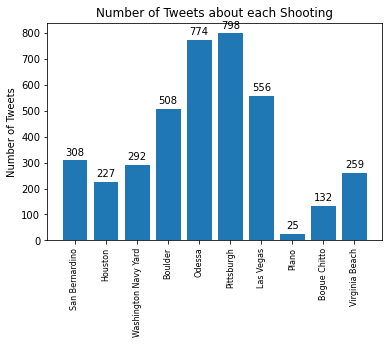

In [71]:
fig, ax = plt.subplots()
ax.set_ylabel('Number of Tweets')
ax.set_title("Number of Tweets about each Shooting")
pps = ax.bar(x=[Shootings.iloc[i,0] for i in range(0, len(Shootings))], height=[Shootings.iloc[i,-1] for i in range(0, len(Shootings))])
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.xticks(rotation = 90)
plt.show()

In [28]:

for i in range(len(corpus)):
    
    days = dict.fromkeys(np.array(range(0,90,5)))


    for j in range(len(corpus[i])):

        d= 
        np.array(range(0,90,5))[np.array(range(0,90,5)) <= 23].max()
    

25
798
556
308
227
774
132
292
508
259


In [46]:
print(list(range(0,90,5)))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]


In [2]:
min(list(range(0,90,5)), key=lambda x: (abs(x - 23), x))

25

In [4]:
min(list(range(0,90,5)), key=lambda x:abs(x-22))

20

In [9]:
np.array(range(0,90,5))

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85])

In [12]:
k = dict.fromkeys(np.array(range(0,90,5)))

20

In [100]:
datetime.strptime(Shootings.iloc[5,5][:10], '%Y-%m-%d').date()-dates[5][4]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'datetime.timedelta'

In [97]:
datetime.today().date()

TypeError: __format__() takes exactly 1 argument (0 given)

In [17]:
from datetime import date
f_date = date(2014, 7, 2)
l_date = date(2014, 7, 11)
delta = l_date - f_date
print(delta.days)

{0: None,
 5: None,
 10: None,
 15: None,
 20: None,
 25: None,
 30: None,
 35: None,
 40: None,
 45: None,
 50: None,
 55: None,
 60: None,
 65: None,
 70: None,
 75: None,
 80: None,
 85: None}

In [77]:
len(dates[-1].tolist())
    

AttributeError: 'list' object has no attribute 'tolist'

In [47]:
with open(f"TwitterData/Tweets_Virginia.json",'r') as f:
    Shooting = json.load(f)
    


In [48]:
Shooting = pd.read_json(Shooting)

Shooting = Shooting.drop([19968, 87939])


In [81]:
Shootings

,City Or County,Shooting Name Sum,Shooting Sum,Shooter Name Sum,Incident ID,Incident Date,State,Address,# Killed,# Injured,Location Type,Gender of Killed,Avg Age of Killed,Majority racialized victims,Shooter Name,Shooter Age,Shooter Race,Shooter after the shooting,Total Tweets,Tweets on Topic
0,San Bernardino,228.0,5101.0,2017.0,456893,2015-12-02 00:00:00,California,1365 South Waterman Ave,16,19,public space,0.357143,41.928571,0.0,Rizwan Farook and Tashfeen Malik,28.0,pakistani,killed by police,33926,308
1,Houston,2.0,2401.0,0.0,390526,2015-08-08 00:00:00,Texas,2211 Falling Oaks,8,0,private space,0.250000,18.250000,1.0,David Ray Conley,48.0,black,arrested by police,55100,227
2,Washington Navy Yard,51.0,928.0,489.0,480366,2013-09-16 00:00:00,District of Columbia,1336 Isaac Hull Ave,13,3,public space,0.285714,57.714286,0.0,Aaron Alexis,34.0,black,killed by police,52456,292
3,Boulder,271.0,9394.0,357.0,1958652,2021-03-22 00:00:00,Colorado,3600 Table Mesa Dr,10,1,public space,0.600000,46.600000,0.0,Ahmad Al Aliwi Al-Issa,21.0,syrian-american,arrested by police,115561,508
4,Odessa,46.0,5569.0,493.0,1492441,2019-08-31 00:00:00,Texas,8250 TX 191,8,23,public space,0.285714,31.857143,1.0,Seth Aaron Ator,36.0,white,killed by police,103185,774
5,Pittsburgh,56.0,6669.0,911.0,1241819,2018-10-27 00:00:00,Pennsylvania,5898 Wilkins Ave,11,7,religious space,0.363636,74.000000,1.0,Robert Gregory Bowers,46.0,white,killed by police,63341,798
6,Las Vegas,1340.0,19302.0,8674.0,946496,2017-10-01 00:00:00,Nevada,3950 Las Vegas Blvd S,59,441,public space,0.620690,38.379310,0.0,Stephen Paddock,64.0,White,Suicide,71655,556
7,Plano,4.0,19345.0,132.0,930569,2017-09-10 00:00:00,Texas,1712 West Spring Creek Parkway,9,1,private space,0.375000,27.375000,0.0,Spencer Hight,32.0,white,killed by police,76902,25
8,Bogue Chitto,0.0,4035.0,0.0,853756,2017-05-27 00:00:00,Mississippi,2871 Lee Dr,8,1,private space,0.500000,37.375000,1.0,Willie Cory Godbolt,35.0,black,arrested by police,73972,132
9,Virginia Beach,65.0,11598.0,381.0,1410442,2019-05-31 00:00:00,Virginia,2405 Courthouse Drive,13,4,public space,0.416667,51.583333,0.0,DeWayne Craddock,40.0,black,killed by police,62924,259


In [53]:
Shooting = Shooting.drop_duplicates()

In [ ]:
df[df['Your_Column'].isin([3, 6])]

In [62]:
Shooting[Shooting['text'].isin(['My heart goes out to those who were affected by the senseless acts of violence that occurred in Virginia Beach yesterday.  https://t.co/jrK70wWLZs', '12 people lost their lives because of gun violence in Virginia Beach.'])].date

75    2019-06-01 21:07:29 UTC
Name: date, dtype: object